## Data Preprocessing

In [2]:
# Data manipulation
import numpy as np
import pandas as pd
import random

# Preprocessing and scaling
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Feature selection
from sklearn.feature_selection import RFE

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.exceptions import ConvergenceWarning

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    roc_curve,
)

# Statistical functions
import scipy.stats as stats

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# General settings
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("training_data_fall2024.csv")

In [4]:
data['increase_stock'] = data['increase_stock'].apply(lambda x: 1 if x == 'high_bike_demand' else 0)

In [5]:
data['snow'].unique()
# Drop the 'snow' column because it provides no additional information
data = data.drop('snow', axis=1)

In [6]:
# Rush Hour (7 AM - 9 AM, 4 PM - 6 PM)
#IF ANYONE WANTS TO CHANGE THIS, FEEL FREE
data['rush_hour'] = data['hour_of_day'].apply(lambda x: 1 if (7 <= x <= 9) else (2 if (16 <= x <= 18) else 0))

# Season (1 = Spring, 2 = Summer, 3 = Fall, 4 = Winter)
def get_season(month):
    if month in [3, 4, 5]: return 1  # Spring
    elif month in [6, 7, 8]: return 2  # Summer
    elif month in [9, 10, 11]: return 3  # Fall
    else: return 4  # Winter
data['season'] = data['month'].apply(get_season)

# Period of the day (Night, Morning, Afternoon, Evening, Late Night)
def get_period(hour_of_day):
    if hour_of_day in range(0, 7): return 0  # Night (12 AM - 6 AM)
    elif hour_of_day in range(7, 12): return 1  # Morning (7 AM - 11 AM)
    elif hour_of_day in range(12, 17): return 2  # Afternoon (12 PM - 4 PM)
    elif hour_of_day in range(17, 21): return 3  # Evening (5 PM - 8 PM)
    else: return 4  # Late Night (9 PM - 11 PM)

data['period_of_day'] = data['hour_of_day'].apply(get_period)

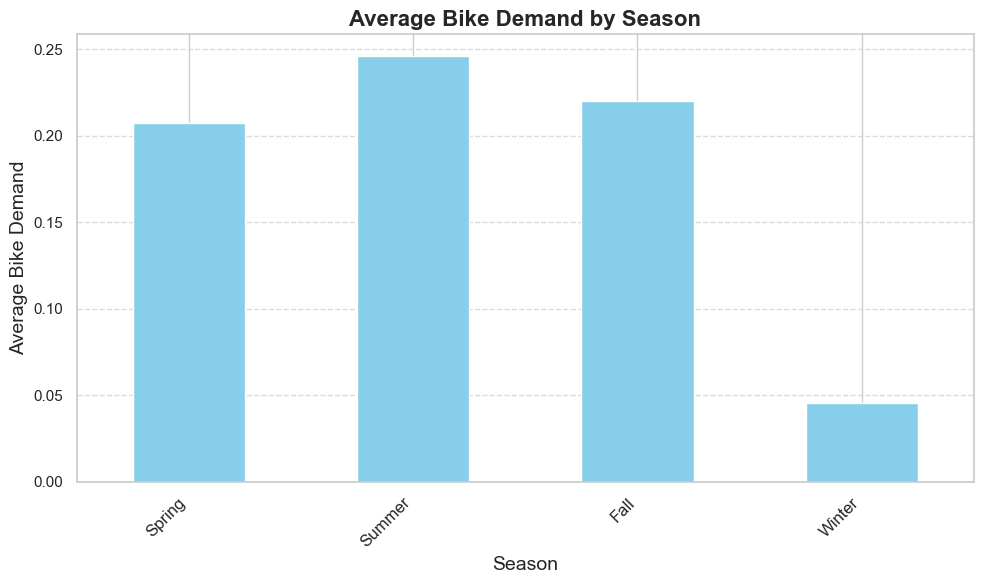

In [7]:
season_labels = ['Spring', 'Summer', 'Fall', 'Winter']

sns.set(style="whitegrid")
ax = data.groupby('season')['increase_stock'].mean().plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Average Bike Demand by Season', fontsize=16, fontweight='bold')
plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Bike Demand', fontsize=14)
plt.xticks(ticks=range(len(season_labels)), labels=season_labels, rotation=45, ha='right', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

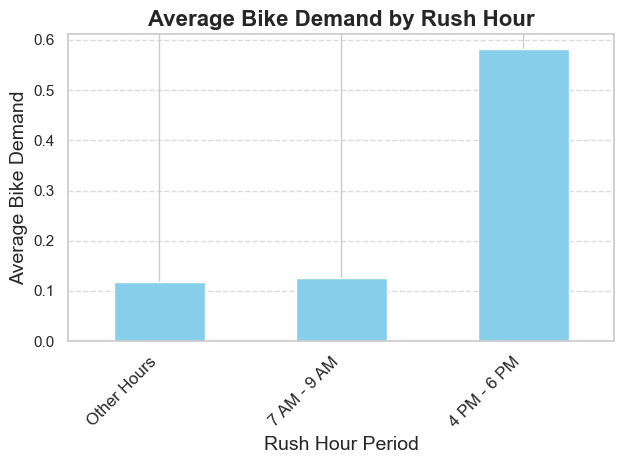

In [8]:
#IF ANYONE WANTS TO CHANGE THIS, FEEL FREE

day_labels = ['Other Hours', '7 AM - 9 AM', '4 PM - 6 PM']

sns.set(style="whitegrid")
ax = data.groupby('rush_hour')['increase_stock'].mean().plot(kind='bar', color='skyblue', title='Average increase_stock Value by Rush Hour')
plt.title('Average Bike Demand by Rush Hour', fontsize=16, fontweight='bold')
plt.xlabel('Rush Hour Period', fontsize=14)
plt.ylabel('Average Bike Demand', fontsize=14)
plt.xticks(ticks=range(len(day_labels)), labels=day_labels, rotation=45, ha='right', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

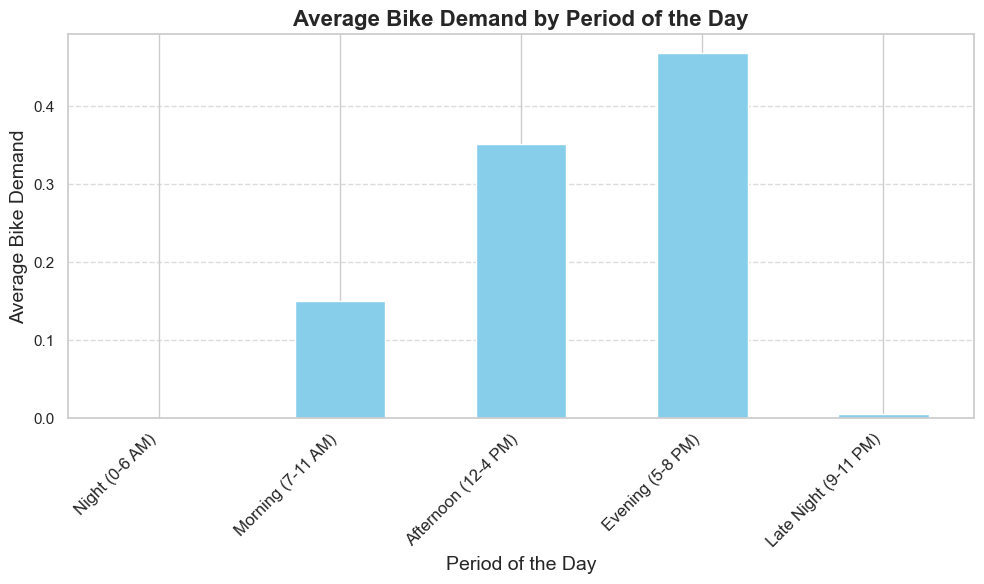

In [9]:
period_labels = ['Night (0-6 AM)', 'Morning (7-11 AM)', 'Afternoon (12-4 PM)', 'Evening (5-8 PM)', 'Late Night (9-11 PM)']

sns.set(style="whitegrid")
ax = data.groupby('period_of_day')['increase_stock'].mean().plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Average Bike Demand by Period of the Day', fontsize=16, fontweight='bold')
plt.xlabel('Period of the Day', fontsize=14)
plt.ylabel('Average Bike Demand', fontsize=14)
plt.xticks(ticks=range(len(period_labels)), labels=period_labels, rotation=45, ha='right', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
data.head(10)

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snowdepth,windspeed,cloudcover,visibility,increase_stock,rush_hour,season,period_of_day
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.0,0.0,16.3,31.6,16.0,0,0,4,0
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.0,0.0,23.9,85.7,16.0,0,0,4,4
2,21,3,8,0,1,1,26.9,21.8,73.39,0.0,0.0,0.0,81.1,16.0,0,0,2,4
3,1,6,1,0,0,0,3.1,-4.0,59.74,0.0,0.0,19.2,0.0,16.0,0,0,4,0
4,17,0,3,0,1,0,11.7,-11.4,18.71,0.0,0.0,10.5,44.6,16.0,0,2,1,3
5,17,3,3,0,1,1,27.1,12.8,40.98,0.0,0.0,13.6,81.3,16.0,1,2,1,3
6,20,4,7,0,1,1,30.9,24.3,67.71,0.0,0.0,20.3,50.3,16.0,0,0,2,3
7,0,1,12,0,1,0,4.9,-1.7,62.46,0.0,0.0,21.5,100.0,16.0,0,0,4,0
8,18,0,11,0,1,0,16.6,13.8,83.56,0.0,0.0,18.1,88.9,16.0,0,2,3,3
9,7,5,1,0,0,0,-4.5,-12.2,55.14,0.0,0.0,12.4,24.4,16.0,0,1,4,1


In [11]:
data['heat_index'] = data['temp'] * data['humidity']

In [12]:
data['increase_stock'].unique()

array([0, 1])

In [13]:
bin_edges = [-10, 0, 10, 20, 30, 40]
bin_labels = [0, 1, 2, 3, 4]  

data['temp_binned'] = pd.cut(data['temp'], bins=bin_edges, labels=bin_labels, right=False)
data['temp_binned'] = data['temp_binned'].astype(int)

In [14]:
data['temp_humidity_ratio'] = data['temp'] / (data['humidity'] + 1e-5)  # Avoid division by zero
data['temp_plus_humidity'] = data['temp'] + data['humidity']

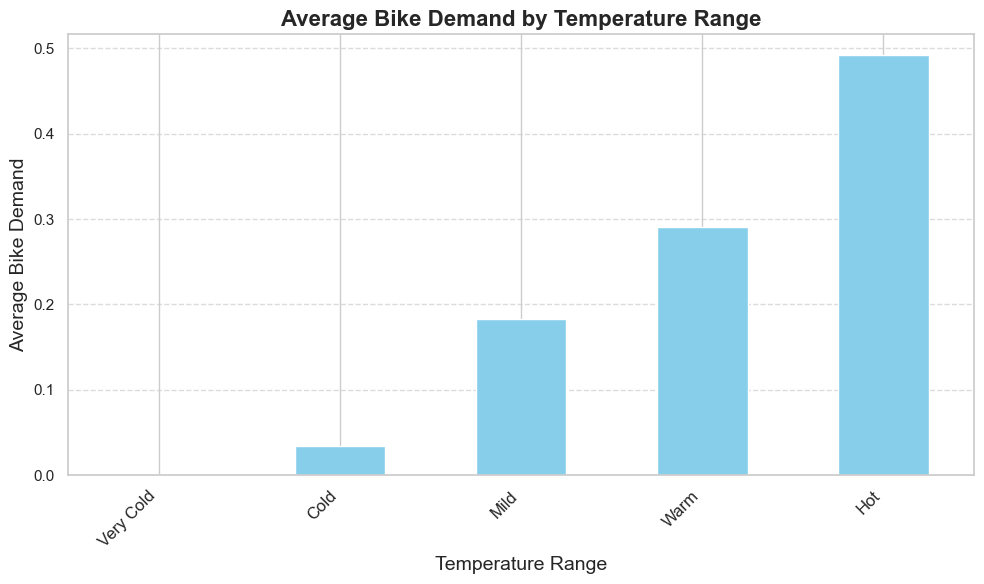

In [15]:
bin_labels = ['Very Cold', 'Cold', 'Mild', 'Warm', 'Hot']

sns.set(style="whitegrid")
ax = data.groupby('temp_binned', observed=False)['increase_stock'].mean().plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Average Bike Demand by Temperature Range', fontsize=16, fontweight='bold')
plt.xlabel('Temperature Range', fontsize=14)
plt.ylabel('Average Bike Demand', fontsize=14)
plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=45, ha='right', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [16]:
data = data.dropna()
data.shape

(1600, 22)

In [17]:
train, test = train_test_split(data, test_size=0.2, random_state=42)
y_train = train['increase_stock']
y_test = test['increase_stock']
X_train = train.drop(columns=['increase_stock'])
X_test = test.drop(columns=['increase_stock'])

In [18]:
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (1280, 21)
X_test Shape: (320, 21)
y_train Shape: (1280,)
y_test Shape: (320,)


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hour_of_day          1600 non-null   int64  
 1   day_of_week          1600 non-null   int64  
 2   month                1600 non-null   int64  
 3   holiday              1600 non-null   int64  
 4   weekday              1600 non-null   int64  
 5   summertime           1600 non-null   int64  
 6   temp                 1600 non-null   float64
 7   dew                  1600 non-null   float64
 8   humidity             1600 non-null   float64
 9   precip               1600 non-null   float64
 10  snowdepth            1600 non-null   float64
 11  windspeed            1600 non-null   float64
 12  cloudcover           1600 non-null   float64
 13  visibility           1600 non-null   float64
 14  increase_stock       1600 non-null   int64  
 15  rush_hour            1600 non-null   i

## Model Selection

### Naive Model

This code evaluates a naive random baseline model, which generates random binary predictions and probabilities. It computes key performance metrics such as accuracy, precision, recall, F1-score, and ROC-AUC, providing a benchmark for comparison against more sophisticated models.

In [22]:
# Set the seed for reproducibility
random.seed(42)

def naive_random_model(size, return_probabilities=False):
    predictions = [random.choice([0, 1]) for _ in range(size)]
    if return_probabilities:
        probabilities = [random.random() for _ in range(size)]
        return predictions, probabilities
    return predictions

predictions, probabilities = naive_random_model(len(y_test), return_probabilities=True)
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')
roc_auc = roc_auc_score(y_test, probabilities)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=["low demand", "high demand"]))

Accuracy: 0.534
Precision: 0.144
Recall: 0.400
F1-Score: 0.212
ROC-AUC: 0.507

Classification Report:
              precision    recall  f1-score   support

  low demand       0.83      0.56      0.67       270
 high demand       0.14      0.40      0.21        50

    accuracy                           0.53       320
   macro avg       0.49      0.48      0.44       320
weighted avg       0.73      0.53      0.60       320



### Logistic Regression

This code trains a logistic regression model on the provided training data and then evaluates its performance on the test set using multiple metrics. It provides a detailed report of how well the model performs in terms of classification accuracy, precision, recall, F1-score, and ROC-AUC, offering a clear comparison to the naive random model.

In [24]:
#Base Model

scaler = StandardScaler()
X_train_new = scaler.fit_transform(X_train)
X_test_new = scaler.transform(X_test)

# Compute class weights for imbalanced classes
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Initialize and fit the logistic regression model
model = LogisticRegression(random_state=42, class_weight=class_weights)
model.fit(X_train_new, y_train)

# Make predictions and calculate probabilities
predictions = model.predict(X_test_new)
probabilities = model.predict_proba(X_test_new)[:, 1]  # Probabilities for class 1

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')
roc_auc = roc_auc_score(y_test, probabilities)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=["low demand", "high demand"]))

Accuracy: 0.778
Precision: 0.392
Recall: 0.760
F1-Score: 0.517
ROC-AUC: 0.844

Classification Report:
              precision    recall  f1-score   support

  low demand       0.95      0.78      0.86       270
 high demand       0.39      0.76      0.52        50

    accuracy                           0.78       320
   macro avg       0.67      0.77      0.69       320
weighted avg       0.86      0.78      0.80       320



In [25]:
# Finding out what the best features are

# Compute class weights
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Define the model with fixed hyperparameters
model = LogisticRegression(
    random_state=42,
    class_weight=class_weights
)

# Define the pipeline with scaling and RFE feature selection
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler step
    ('feature_selection', RFE(estimator=model, n_features_to_select=5)),  # RFE step
    ('model', model)  # Logistic Regression model
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Get selected features
feature_selector = pipeline.named_steps['feature_selection']
selected_features = X_train.columns[feature_selector.support_]
print(f"Selected Features: {selected_features}")

# Make predictions
predictions = pipeline.predict(X_test)
probabilities = pipeline.predict_proba(X_test)[:, 1]

# Evaluation (optional)
accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, probabilities)
print(f"Accuracy: {accuracy:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

Selected Features: Index(['hour_of_day', 'temp', 'precip', 'period_of_day', 'heat_index'], dtype='object')
Accuracy: 0.731
ROC-AUC: 0.794


In [26]:
# Model with the best possible parameters, prioritizing ROC-AUC 

features = ['hour_of_day', 'temp', 'precip', 'period_of_day', 'heat_index']

# Subset the training and testing data to include only the selected features
X_train_new = X_train[features]
X_test_new = X_test[features]

# Compute class weights
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Parameter grid
param_grid = {
    'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 200, 300],
    'model__solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
    'model__max_iter': [100, 200, 300, 500],
    'model__tol': [1e-4, 1e-3, 1e-2],
    'model__fit_intercept': [True, False]
}

# Pipeline with scaler and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42, class_weight=class_weights))
])

# Suppress warnings during grid search
scoring = 'roc_auc'
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_new, y_train)

# Best parameters and evaluation
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best {scoring} Score: {grid_search.best_score_}")

# Predictions
predictions = best_model.predict(X_test_new)
probabilities = best_model.predict_proba(X_test_new)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')
roc_auc = roc_auc_score(y_test, probabilities)

# Results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=["low demand", "high demand"]))

Fitting 5 folds for each of 3072 candidates, totalling 15360 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

Best Parameters: {'model__C': 100, 'model__fit_intercept': False, 'model__max_iter': 200, 'model__penalty': 'l2', 'model__solver': 'saga', 'model__tol': 0.001}
Best roc_auc Score: 0.8695327590825561
Accuracy: 0.653
Precision: 0.284
Recall: 0.800
F1-Score: 0.419
ROC-AUC: 0.790

Classification Report:
              precision    recall  f1-score   support

  low demand       0.94      0.63      0.75       270
 high demand       0.28      0.80      0.42        50

    accuracy                           0.65       320
   macro avg       0.61      0.71      0.59       320
weighted avg       0.84      0.65      0.70       320



In [27]:
 # Final Model 

# Selected features
features = ['hour_of_day', 'temp', 'precip', 'period_of_day', 'heat_index']

# Subset the training and testing data to include only the selected features
X_train_new = X_train[features]
X_test_new = X_test[features]

# Compute class weights
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Define the model with the specified parameters
model = LogisticRegression(
    random_state=42,
    C=100,
    fit_intercept=False,
    max_iter=200,
    penalty='l2',
    solver='saga',
    tol=0.001,
    class_weight=class_weights,
)

# Pipeline with scaler and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler step
    ('model', model)  # Logistic Regression model with predefined parameters
])

# Fit the pipeline
pipeline.fit(X_train_new, y_train)

# Predictions
predictions = pipeline.predict(X_test_new)
probabilities = pipeline.predict_proba(X_test_new)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')
roc_auc = roc_auc_score(y_test, probabilities)

# Results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=["low demand", "high demand"]))

Accuracy: 0.653
Precision: 0.284
Recall: 0.800
F1-Score: 0.419
ROC-AUC: 0.790

Classification Report:
              precision    recall  f1-score   support

  low demand       0.94      0.63      0.75       270
 high demand       0.28      0.80      0.42        50

    accuracy                           0.65       320
   macro avg       0.61      0.71      0.59       320
weighted avg       0.84      0.65      0.70       320



### Decision Tree Classifier

In [29]:
#Base Model

scaler = StandardScaler()
X_train_new = scaler.fit_transform(X_train)
X_test_new = scaler.transform(X_test)

# Compute class weights for imbalanced classes
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Initialize and fit the logistic regression model
model = DecisionTreeClassifier(random_state=42, class_weight=class_weights)
model.fit(X_train_new, y_train)

# Make predictions and calculate probabilities
predictions = model.predict(X_test_new)
probabilities = model.predict_proba(X_test_new)[:, 1]  # Probabilities for class 1

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')
roc_auc = roc_auc_score(y_test, probabilities)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=["low demand", "high demand"]))

Accuracy: 0.847
Precision: 0.509
Recall: 0.580
F1-Score: 0.542
ROC-AUC: 0.738

Classification Report:
              precision    recall  f1-score   support

  low demand       0.92      0.90      0.91       270
 high demand       0.51      0.58      0.54        50

    accuracy                           0.85       320
   macro avg       0.71      0.74      0.73       320
weighted avg       0.86      0.85      0.85       320



In [30]:
# Finding out what the best features are

# Compute class weights
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Define the model with fixed hyperparameters
model = DecisionTreeClassifier(
    random_state=42,
    class_weight=class_weights
)

# Define the pipeline with scaling and RFE feature selection
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler step
    ('feature_selection', RFE(estimator=model, n_features_to_select=5)),  # RFE step
    ('model', model)  # Decision Tree Classifier model
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Get selected features
feature_selector = pipeline.named_steps['feature_selection']
selected_features = X_train.columns[feature_selector.support_]
print(f"Selected Features: {selected_features}")

# Make predictions
predictions = pipeline.predict(X_test)
probabilities = pipeline.predict_proba(X_test)[:, 1]

# Evaluation (optional)
accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, probabilities)
print(f"Accuracy: {accuracy:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

Selected Features: Index(['hour_of_day', 'temp', 'windspeed', 'heat_index',
       'temp_humidity_ratio'],
      dtype='object')
Accuracy: 0.825
ROC-AUC: 0.676


In [31]:
# Model with the best possible parameters, prioritizing ROC-AUC 

features = ['hour_of_day', 'temp', 'windspeed', 'heat_index', 'temp_humidity_ratio']

# Subset the training and testing data to include only the selected features
X_train_new = X_train[features]
X_test_new = X_test[features]

# Compute class weights
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Parameter grid
param_grid = {
    'model__criterion': ['gini', 'entropy'],  # Split criterion
    'model__max_depth': [None, 5, 10, 15, 20],  # Maximum depth of the tree
    'model__min_samples_split': [2, 5, 10, 20],  # Minimum samples required to split a node
    'model__min_samples_leaf': [1, 2, 5, 10],  # Minimum samples required at a leaf node
    'model__max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider for splits
    'model__splitter': ['best', 'random'],  # Split strategy
}


# Pipeline with scaler and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeClassifier(random_state=42, class_weight=class_weights))
])

# Suppress warnings during grid search
scoring = 'roc_auc'
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_new, y_train)

# Best parameters and evaluation
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best {scoring} Score: {grid_search.best_score_}")

# Predictions
predictions = best_model.predict(X_test_new)
probabilities = best_model.predict_proba(X_test_new)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')
roc_auc = roc_auc_score(y_test, probabilities)

# Results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=["low demand", "high demand"]))

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits
Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__splitter': 'best'}
Best roc_auc Score: 0.9023481426538188
Accuracy: 0.769
Precision: 0.389
Recall: 0.840
F1-Score: 0.532
ROC-AUC: 0.870

Classification Report:
              precision    recall  f1-score   support

  low demand       0.96      0.76      0.85       270
 high demand       0.39      0.84      0.53        50

    accuracy                           0.77       320
   macro avg       0.68      0.80      0.69       320
weighted avg       0.87      0.77      0.80       320



In [32]:
 # Final Model 

# Selected features
features = ['hour_of_day', 'temp', 'windspeed', 'heat_index', 'temp_humidity_ratio']

# Subset the training and testing data to include only the selected features
X_train_new = X_train[features]
X_test_new = X_test[features]

# Compute class weights
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Define the model with the specified parameters
model = DecisionTreeClassifier(
    criterion='entropy',  # Split criterion
    max_depth=5,  # Maximum depth of the tree
    max_features=None,  # No feature restriction for splits
    min_samples_leaf=1,  # Minimum samples required at a leaf node
    min_samples_split=2,  # Minimum samples required to split a node
    splitter='best',  # Use the best split strategy
    class_weight=class_weights,  # Handle class imbalance
    random_state=42  # For reproducibility
)

# Pipeline with scaler and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler step
    ('model', model)  # Decision Tree Classifier model with predefined parameters
])


# Fit the pipeline
pipeline.fit(X_train_new, y_train)

# Predictions
predictions = pipeline.predict(X_test_new)
probabilities = pipeline.predict_proba(X_test_new)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')
roc_auc = roc_auc_score(y_test, probabilities)

# Results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=["low demand", "high demand"]))

Accuracy: 0.769
Precision: 0.389
Recall: 0.840
F1-Score: 0.532
ROC-AUC: 0.870

Classification Report:
              precision    recall  f1-score   support

  low demand       0.96      0.76      0.85       270
 high demand       0.39      0.84      0.53        50

    accuracy                           0.77       320
   macro avg       0.68      0.80      0.69       320
weighted avg       0.87      0.77      0.80       320



### Random Forest Classifier

In [34]:
#Base Model

scaler = StandardScaler()
X_train_new = scaler.fit_transform(X_train)
X_test_new = scaler.transform(X_test)

# Compute class weights for imbalanced classes
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Initialize and fit the logistic regression model
model = RandomForestClassifier(random_state=42, class_weight=class_weights)
model.fit(X_train_new, y_train)

# Make predictions and calculate probabilities
predictions = model.predict(X_test_new)
probabilities = model.predict_proba(X_test_new)[:, 1]  # Probabilities for class 1

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')
roc_auc = roc_auc_score(y_test, probabilities)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=["low demand", "high demand"]))

Accuracy: 0.872
Precision: 0.596
Recall: 0.560
F1-Score: 0.577
ROC-AUC: 0.897

Classification Report:
              precision    recall  f1-score   support

  low demand       0.92      0.93      0.92       270
 high demand       0.60      0.56      0.58        50

    accuracy                           0.87       320
   macro avg       0.76      0.74      0.75       320
weighted avg       0.87      0.87      0.87       320



In [35]:
# Finding out what the best features are

# Compute class weights
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Define the model with fixed hyperparameters
model = RandomForestClassifier(
    random_state=42,
    class_weight=class_weights
)

# Define the pipeline with scaling and RFE feature selection
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler step
    ('feature_selection', RFE(estimator=model, n_features_to_select=5)),  # RFE step
    ('model', model)  # Random Forest Classifier model
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Get selected features
feature_selector = pipeline.named_steps['feature_selection']
selected_features = X_train.columns[feature_selector.support_]
print(f"Selected Features: {selected_features}")

# Make predictions
predictions = pipeline.predict(X_test)
probabilities = pipeline.predict_proba(X_test)[:, 1]

# Evaluation (optional)
accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, probabilities)
print(f"Accuracy: {accuracy:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

Selected Features: Index(['hour_of_day', 'temp', 'humidity', 'period_of_day',
       'temp_humidity_ratio'],
      dtype='object')
Accuracy: 0.844
ROC-AUC: 0.867


In [36]:
# Model with the best possible parameters, prioritizing ROC-AUC 

features = ['hour_of_day', 'temp', 'humidity', 'period_of_day', 'temp_humidity_ratio']

# Subset the training and testing data to include only the selected features
X_train_new = X_train[features]
X_test_new = X_test[features]

# Compute class weights
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Parameter grid for RandomForestClassifier
param_grid = {
    'model__n_estimators': [100, 200, 500],  # Number of trees in the forest
    'model__criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'model__max_depth': [None, 5, 10, 15],  # Maximum depth of the tree
    'model__min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'model__min_samples_leaf': [1, 2, 5],  # Minimum samples required at each leaf node
    'model__max_features': ['auto', 'sqrt'],  # Number of features to consider for each split
    'model__bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
}


# Pipeline with scaler and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42, class_weight=class_weights))
])

# Suppress warnings during grid search
scoring = 'roc_auc'
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_new, y_train)

# Best parameters and evaluation
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best {scoring} Score: {grid_search.best_score_}")

# Predictions
predictions = best_model.predict(X_test_new)
probabilities = best_model.predict_proba(X_test_new)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')
roc_auc = roc_auc_score(y_test, probabilities)

# Results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=["low demand", "high demand"]))

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best Parameters: {'model__bootstrap': True, 'model__criterion': 'entropy', 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 500}
Best roc_auc Score: 0.9317689612552436
Accuracy: 0.841
Precision: 0.493
Recall: 0.740
F1-Score: 0.592
ROC-AUC: 0.885

Classification Report:
              precision    recall  f1-score   support

  low demand       0.95      0.86      0.90       270
 high demand       0.49      0.74      0.59        50

    accuracy                           0.84       320
   macro avg       0.72      0.80      0.75       320
weighted avg       0.88      0.84      0.85       320



In [37]:
 # Final Model 

# Selected features
features = ['hour_of_day', 'temp', 'humidity', 'period_of_day', 'temp_humidity_ratio']

# Subset the training and testing data to include only the selected features
X_train_new = X_train[features]
X_test_new = X_test[features]

# Compute class weights
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Define the model with the specified parameters for RandomForestClassifier
model = RandomForestClassifier(
    bootstrap=True,
    criterion='entropy',
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=5,
    min_samples_split=2,
    n_estimators=500,
    class_weight=class_weights,
    random_state=42
)

# Pipeline with scaler and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler step
    ('model', model)  # Decision Tree Classifier model with predefined parameters
])

# Fit the pipeline
pipeline.fit(X_train_new, y_train)

# Predictions
predictions = pipeline.predict(X_test_new)
probabilities = pipeline.predict_proba(X_test_new)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')
roc_auc = roc_auc_score(y_test, probabilities)

# Results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=["low demand", "high demand"]))

Accuracy: 0.841
Precision: 0.493
Recall: 0.740
F1-Score: 0.592
ROC-AUC: 0.885

Classification Report:
              precision    recall  f1-score   support

  low demand       0.95      0.86      0.90       270
 high demand       0.49      0.74      0.59        50

    accuracy                           0.84       320
   macro avg       0.72      0.80      0.75       320
weighted avg       0.88      0.84      0.85       320



### KNN Classifier

In [39]:
# Base Model using KNN

# Scaling the data
scaler = StandardScaler()
X_train_new = scaler.fit_transform(X_train)
X_test_new = scaler.transform(X_test)

# Compute class weights for imbalanced classes
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Initialize and fit the KNN model
model = KNeighborsClassifier(
    n_neighbors=5,  
    weights='uniform', 
    algorithm='auto',  
    p=2,
)

model.fit(X_train_new, y_train)

# Make predictions and calculate probabilities
predictions = model.predict(X_test_new)
probabilities = model.predict_proba(X_test_new)[:, 1]  # Probabilities for class 1

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')
roc_auc = roc_auc_score(y_test, probabilities)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=["low demand", "high demand"]))

Accuracy: 0.859
Precision: 0.561
Recall: 0.460
F1-Score: 0.505
ROC-AUC: 0.802

Classification Report:
              precision    recall  f1-score   support

  low demand       0.90      0.93      0.92       270
 high demand       0.56      0.46      0.51        50

    accuracy                           0.86       320
   macro avg       0.73      0.70      0.71       320
weighted avg       0.85      0.86      0.85       320



In [40]:
# Model with the best possible parameters, prioritizing ROC-AUC 

features = ['hour_of_day', 'temp', 'humidity', 'period_of_day', 'temp_humidity_ratio', 'windspeed', 'heat_index', 'precip']
# Subset the training and testing data to include only the selected features
X_train_new = X_train[features]
X_test_new = X_test[features]

# Compute class weights
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Parameter grid for RandomForestClassifier
param_grid = {
    'model__n_neighbors': [3, 5, 7, 10, 15, 20],  # Number of neighbors
    'model__weights': ['uniform', 'distance'],  # Weight function
    'model__metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
    'model__p': [1, 2],  # Power parameter for Minkowski distance (1=Manhattan, 2=Euclidean)
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm for nearest neighbors search
    'model__leaf_size': [10, 20, 30, 40]  # Leaf size for BallTree and KDTree algorithms
}


# Pipeline with scaler and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
])

# Suppress warnings during grid search
scoring = 'roc_auc'
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_new, y_train)

# Best parameters and evaluation
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best {scoring} Score: {grid_search.best_score_}")

# Predictions
predictions = best_model.predict(X_test_new)
probabilities = best_model.predict_proba(X_test_new)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')
roc_auc = roc_auc_score(y_test, probabilities)

# Results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=["low demand", "high demand"]))

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Best Parameters: {'model__algorithm': 'auto', 'model__leaf_size': 10, 'model__metric': 'manhattan', 'model__n_neighbors': 20, 'model__p': 1, 'model__weights': 'distance'}
Best roc_auc Score: 0.9122600681093822
Accuracy: 0.850
Precision: 0.521
Recall: 0.500
F1-Score: 0.510
ROC-AUC: 0.864

Classification Report:
              precision    recall  f1-score   support

  low demand       0.91      0.91      0.91       270
 high demand       0.52      0.50      0.51        50

    accuracy                           0.85       320
   macro avg       0.71      0.71      0.71       320
weighted avg       0.85      0.85      0.85       320



In [41]:
 # Final Model 

# Selected features
features = ['hour_of_day', 'temp', 'humidity', 'period_of_day', 'temp_humidity_ratio', 'windspeed', 'heat_index', 'precip']

# Subset the training and testing data to include only the selected features
X_train_new = X_train[features]
X_test_new = X_test[features]

# Compute class weights
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Define the model with the specified parameters for KNeighborsClassifier
model = KNeighborsClassifier(
    algorithm='auto',        # Algorithm for nearest neighbors search
    leaf_size=10,            # Leaf size for BallTree and KDTree algorithms
    metric='manhattan',      # Use Manhattan distance (p=1)
    n_neighbors=20,          # Number of neighbors
    p=1,                     # Power parameter for Minkowski distance (1=Manhattan)
    weights='distance'       # Weight function used in prediction (distance-based weights)
)

# Pipeline with scaler and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler step
    ('model', model)  # KNeighborsClassifier model with predefined parameters
])

# Fit the pipeline
pipeline.fit(X_train_new, y_train)

# Predictions
predictions = pipeline.predict(X_test_new)
probabilities = pipeline.predict_proba(X_test_new)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')
roc_auc = roc_auc_score(y_test, probabilities)

# Results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=["low demand", "high demand"]))

Accuracy: 0.850
Precision: 0.521
Recall: 0.500
F1-Score: 0.510
ROC-AUC: 0.864

Classification Report:
              precision    recall  f1-score   support

  low demand       0.91      0.91      0.91       270
 high demand       0.52      0.50      0.51        50

    accuracy                           0.85       320
   macro avg       0.71      0.71      0.71       320
weighted avg       0.85      0.85      0.85       320



### AdaBoost

In [43]:
# Base Model using AdaBoost

# Scaling the data
scaler = StandardScaler()
X_train_new = scaler.fit_transform(X_train)
X_test_new = scaler.transform(X_test)

# Compute class weights for imbalanced classes
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Initialize AdaBoost model
model = AdaBoostClassifier(
    n_estimators=50,           # Number of boosting rounds
    random_state=42
)

# Fit the model
model.fit(X_train_new, y_train)

# Make predictions and calculate probabilities
predictions = model.predict(X_test_new)
probabilities = model.predict_proba(X_test_new)[:, 1]  # Probabilities for class 1

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')
roc_auc = roc_auc_score(y_test, probabilities)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=["low demand", "high demand"]))


Accuracy: 0.844
Precision: 0.500
Recall: 0.560
F1-Score: 0.528
ROC-AUC: 0.890

Classification Report:
              precision    recall  f1-score   support

  low demand       0.92      0.90      0.91       270
 high demand       0.50      0.56      0.53        50

    accuracy                           0.84       320
   macro avg       0.71      0.73      0.72       320
weighted avg       0.85      0.84      0.85       320



In [44]:
# Finding out what the best features are for AdaBoost

# Compute class weights for imbalanced classes
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Define the AdaBoost model with the base model
model = AdaBoostClassifier(
    n_estimators=50,           # Number of boosting rounds
    random_state=42
)

# Define the pipeline with scaling and RFE feature selection
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler step
    ('feature_selection', RFE(estimator=model, n_features_to_select=5)),  # RFE step for feature selection
    ('model', model)  # AdaBoost model
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Get selected features
feature_selector = pipeline.named_steps['feature_selection']
selected_features = X_train.columns[feature_selector.support_]
print(f"Selected Features: {selected_features}")

# Make predictions
predictions = pipeline.predict(X_test)
probabilities = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, probabilities)
print(f"Accuracy: {accuracy:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")


Selected Features: Index(['hour_of_day', 'temp', 'windspeed', 'heat_index',
       'temp_humidity_ratio'],
      dtype='object')
Accuracy: 0.841
ROC-AUC: 0.880


In [45]:
# Model with the best possible parameters, prioritizing ROC-AUC

# Features to use
features = ['hour_of_day', 'temp', 'windspeed', 'heat_index', 'temp_humidity_ratio']

# Subset the training and testing data to include only the selected features
X_train_new = X_train[features]
X_test_new = X_test[features]

# Compute class weights
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Parameter grid for AdaBoostClassifier
param_grid = {
    'model__n_estimators': [50, 100, 200],  # Number of boosting rounds
    'model__learning_rate': [0.01, 0.1, 0.5, 1.0],  # Learning rate shrinks the contribution of each classifier
    'model__algorithm': ['SAMME', 'SAMME.R'],  # Algorithm to use for boosting
}

# Pipeline with scaler and AdaBoost model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler step
    ('model', AdaBoostClassifier(random_state=42))  # AdaBoost model with default base estimator
])

# Suppress warnings during grid search
scoring = 'roc_auc'
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_new, y_train)

# Best parameters and evaluation
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best {scoring} Score: {grid_search.best_score_}")

# Predictions
predictions = best_model.predict(X_test_new)
probabilities = best_model.predict_proba(X_test_new)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')
roc_auc = roc_auc_score(y_test, probabilities)

# Results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=["low demand", "high demand"]))


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

Best Parameters: {'model__algorithm': 'SAMME', 'model__learning_rate': 1.0, 'model__n_estimators': 200}
Best roc_auc Score: 0.9258360388736403
Accuracy: 0.853
Precision: 0.527
Recall: 0.580
F1-Score: 0.552
ROC-AUC: 0.890

Classification Report:
              precision    recall  f1-score   support

  low demand       0.92      0.90      0.91       270
 high demand       0.53      0.58      0.55        50

    accuracy                           0.85       320
   macro avg       0.72      0.74      0.73       320
weighted avg       0.86      0.85      0.86       320



In [46]:
 # Final Model 

# Selected features
features = ['hour_of_day', 'temp', 'windspeed', 'heat_index', 'temp_humidity_ratio']

# Subset the training and testing data to include only the selected features
X_train_new = X_train[features]
X_test_new = X_test[features]

# Define the model with the specified parameters for RandomForestClassifier
model = AdaBoostClassifier(
    algorithm = 'SAMME',
    learning_rate = 1.0,
    n_estimators = 200,
    random_state=42
)

# Pipeline with scaler and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler step
    ('model', model)  # Decision Tree Classifier model with predefined parameters
])

# Fit the pipeline
pipeline.fit(X_train_new, y_train)

# Predictions
predictions = pipeline.predict(X_test_new)
probabilities = pipeline.predict_proba(X_test_new)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')
roc_auc = roc_auc_score(y_test, probabilities)

# Results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=["low demand", "high demand"]))

Accuracy: 0.853
Precision: 0.527
Recall: 0.580
F1-Score: 0.552
ROC-AUC: 0.890

Classification Report:
              precision    recall  f1-score   support

  low demand       0.92      0.90      0.91       270
 high demand       0.53      0.58      0.55        50

    accuracy                           0.85       320
   macro avg       0.72      0.74      0.73       320
weighted avg       0.86      0.85      0.86       320

